In [ ]:
#| include: false
#| eval: false
! [ -e /content ] && pip install -Uqq gingado nbdev # install or upgrade gingado on colab

In [ ]:
#| default_exp datasets
#| include: false
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| include: false
from nbdev.showdoc import show_doc
from fastcore.test import test_fail
import matplotlib.pyplot as plt
import pandas as pd

## Real datasets

In [ ]:
#| include: false
#| export
import pandas as pd

def load_BarroLee_1994(
    return_tuple:bool=True # Whether to return the data in a tuple or jointly in a single pandas DataFrame
): # `X` and `y` in a tuple or in a single pandas DataFrame
    "Dataset used in R Barro and J-W Lee's *Sources of Economic Growth* (1994)"
    df = pd.read_csv('gingado/dataset_BarroLee_1994.csv')
    if return_tuple:
        y = df.pop('Outcome')
        X = df
        return X, y
    else:
        return df

In [ ]:
show_doc(load_BarroLee_1994)

---

[source](https://github.com/dkgaraujo/gingado/tree/main/blob/main/gingado/datasets.py#L10){target="_blank" style="float:right; font-size:smaller"}

### load_BarroLee_1994

>      load_BarroLee_1994 (return_tuple:bool=True)

Dataset used in R Barro and J-W Lee's *Sources of Economic Growth* (1994)

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| return_tuple | bool | True | Whether to return the data in a tuple or jointly in a single pandas DataFrame |

Robert Barro and Jong-Wha Lee's [-@BARRO19941] dataset has been used over time by other economists, such as by @belloni2011inference and @giannone2021illusion. This function uses the version available in their [online annex](https://onlinelibrary.wiley.com/doi/abs/10.3982/ECTA17842). In that paper, this dataset corresponds to what the authors call "macro2".

The original data, along with more information on the variables, can be found in [this NBER website](http://www2.nber.org/pub/barro.lee/). A very helpful codebook is found [in this repo](https://github.com/bizmaercq/Do-Poor-Countries-Grow-Faster-than-Rich-Countries/blob/master/data/Codebook.txt).

In [ ]:
X, y = load_BarroLee_1994()
X.head()

,Unnamed: 0,gdpsh465,bmp1l,freeop,freetar,h65,hm65,hf65,p65,pm65,...,seccf65,syr65,syrm65,syrf65,teapri65,teasec65,ex1,im1,xr65,tot1
0,0,6.591674,0.2837,0.153491,0.043888,0.007,0.013,0.001,0.29,0.37,...,0.04,0.033,0.057,0.010,47.6,17.3,0.0729,0.0667,0.348,-0.014727
1,1,6.829794,0.6141,0.313509,0.061827,0.019,0.032,0.007,0.91,1.00,...,0.64,0.173,0.274,0.067,57.1,18.0,0.0940,0.1438,0.525,0.005750
2,2,8.895082,0.0000,0.204244,0.009186,0.260,0.325,0.201,1.00,1.00,...,18.14,2.573,2.478,2.667,26.5,20.7,0.1741,0.1750,1.082,-0.010040
3,3,7.565275,0.1997,0.248714,0.036270,0.061,0.070,0.051,1.00,1.00,...,2.63,0.438,0.453,0.424,27.8,22.7,0.1265,0.1496,6.625,-0.002195
4,4,7.162397,0.1740,0.299252,0.037367,0.017,0.027,0.007,0.82,0.85,...,2.11,0.257,0.287,0.229,34.5,17.6,0.1211,0.1308,2.500,0.003283


<AxesSubplot:title={'center':'GDP growth'}, ylabel='Frequency'>

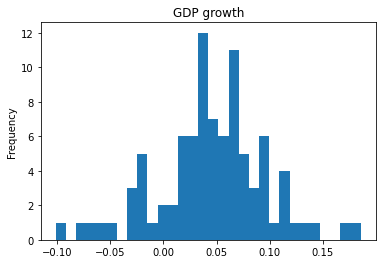

In [ ]:
y.plot.hist(title='GDP growth', bins=30)

## Simulated datasets

:::{.callout-note}

All of the functions creating simulated datasets have a parameter `random_state` that allow for reproducible random numbers.

:::

In [ ]:
#| include: false
#| export
import pandas as pd
import numpy as np
from inspect import signature
from sklearn.utils import check_random_state
from typing import Callable

def make_causal_effect(
    n_samples:int=100, # Number of observations
    n_features:int=100, # Number of covariates
    # Function that generates the outcome variable before any treatment effects
    pretreatment_outcome=lambda X, bias, rng: X[:, 1] + np.maximum(X[:, 2], 0) + bias + rng.standard_normal(size=X.shape[0]), 
    # Number between 0 and 1, or function that generates a treatment propensity for each observation
    treatment_propensity=lambda X: 0.4 + 0.2 * (X[:, 0] > 0),
    # Function that controls how treatment propensities actually result in observations being treated
    treatment_assignment=lambda propensity, rng: rng.binomial(1, propensity),
    # Function that determines the magnitude of the treatment for each observation, conditional on assignment
    treatment=lambda assignment: assignment,
    # Function that calculates the effect of a treatment to each treated observation
    treatment_effect=lambda treatment_value, X: np.maximum(X[:, 0], 0) * treatment_value,
    bias:float=0, # The value of the constant
    noise:float=0, # If 0, the pretreatment value of the overview does not include a random term. If > 0, a random draw of the normal distribution with scale `noise` is drawn
    random_state=None, # Seed for the random number generator
    return_propensity:bool=False, # Whether the treatment propensity of each observation is to be retuned
    return_assignment:bool=False, # Whether the treatment assignment status of each observation is to be retuned
    return_treatment_value:bool=False, # Whether the treatment value of each observation is to be retuned
    return_treatment_effect:bool=True, # Whether the treatment effect of each observation is to be retuned
    return_pretreatment_y:bool=False, # Whether the outcome variable of each observation before the inclusion of treatment effects is to be retuned
    return_as_dict:bool=False # Whether the results are returned as a list (False) or as a dictionary (True)
): # `X`, `y` and any other variables set to return in a list or in a dictionary
    "Simulated dataset with causal effects from treatment"  
    generator = check_random_state(random_state)

    X = generator.standard_normal(size=(n_samples, n_features))

    if 'rng' in signature(pretreatment_outcome).parameters.keys():
        pretreatment_y = pretreatment_outcome(X=X, bias=bias, rng=generator)
    else:
        pretreatment_y = pretreatment_outcome(X=X, bias=bias)
    pretreatment_y = np.squeeze(pretreatment_y)
    if noise > 0.0:
        pretreatment_y += generator.normal(scale=noise, size=pretreatment_y.shape)

    # Since propensity may be a scalar (ie, the same propensity for all),
    # it is necessary to first check that it is callable.
    if callable(treatment_propensity):
        propensity = treatment_propensity(X=X)
    else:
        propensity = np.broadcast_to(treatment_propensity, pretreatment_y.shape)

    if 'rng' in signature(treatment_assignment).parameters.keys():
        assignment = treatment_assignment(propensity=propensity, rng=generator)
    else:
        assignment = treatment_assignment(propensity=propensity)

    # In case treatment is heterogenous amongst the treated observations,
    # the treatment function depends on `X`; otherwise only on `assignment`
    if 'X' in signature(treatment).parameters.keys():
        treatment_value = treatment(assignment=assignment, X=X)
    else:
        treatment_value = treatment(assignment=assignment)

    if len(treatment_value) == 1: treatment_value = treatment_value[0]

    # check that the treatment value is 0 for all observations that
    # are not assigned for treatment
    treatment_check = np.column_stack((assignment, treatment_value))
    if all(treatment_check[treatment_check[:, 0] == 0, 1] == 0) is False:
        raise ValueError("Argument `treatment` must be a function that returns 0 for observations with `assignment` == 0.\nOne suggestion is to multiply the desired treatment value with `assignment`.")

    # the code below checks whether the treatment effect responds to each unit's covariates
    # if not, then it just passes the treatment variable to `treatment_effect`
    if 'X' in signature(treatment_effect).parameters.keys(): 
        treat = treatment_effect(treatment_value=treatment_value, X=X)
    else:
        treat = treatment_effect(treatment_value=treatment_value)

    y = pretreatment_y + treat

    return_items = {'X': X, 'y': y}

    if return_propensity: return_items['propensity'] = propensity
    if return_assignment: return_items['treatment_assignment'] = assignment
    if return_treatment_value: return_items['treatment_value'] = treatment_value,
    if return_treatment_effect: return_items['treatment_effect'] = treat
    if return_pretreatment_y: return_items['pretreatment_y'] = pretreatment_y

    if return_as_dict == False:
        return_items = [v for k, v in return_items.items()]

    return return_items

In [ ]:
show_doc(make_causal_effect)

---

[source](https://github.com/dkgaraujo/gingado/tree/main/blob/main/gingado/datasets.py#L25){target="_blank" style="float:right; font-size:smaller"}

### make_causal_effect

>      make_causal_effect (n_samples:int=100, n_features:int=100,
>                          pretreatment_outcome=<function <lambda>>,
>                          treatment_propensity=<function <lambda>>,
>                          treatment_assignment=<function <lambda>>,
>                          treatment=<function <lambda>>,
>                          treatment_effect=<function <lambda>>, bias:float=0,
>                          noise:float=0, random_state=None,
>                          return_propensity:bool=False,
>                          return_assignment:bool=False,
>                          return_treatment_value:bool=False,
>                          return_treatment_effect:bool=True,
>                          return_pretreatment_y:bool=False,
>                          return_as_dict:bool=False)

Simulated dataset with causal effects from treatment

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| n_samples | int | 100 | Number of observations |
| n_features | int | 100 | Number of covariates |
| pretreatment_outcome | function | <lambda> | Function that generates the outcome variable before any treatment effects |
| treatment_propensity | function | <lambda> | Number between 0 and 1, or function that generates a treatment propensity for each observation |
| treatment_assignment | function | <lambda> | Function that controls how treatment propensities actually result in observations being treated |
| treatment | function | <lambda> | Function that determines the magnitude of the treatment for each observation, conditional on assignment |
| treatment_effect | function | <lambda> | Function that calculates the effect of a treatment to each treated observation |
| bias | float | 0 | The value of the constant |
| noise | float | 0 | If 0, the pretreatment value of the overview does not include a random term. If > 0, a random draw of the normal distribution with scale `noise` is drawn |
| random_state | NoneType | None | Seed for the random number generator |
| return_propensity | bool | False | Whether the treatment propensity of each observation is to be retuned |
| return_assignment | bool | False | Whether the treatment assignment status of each observation is to be retuned |
| return_treatment_value | bool | False | Whether the treatment value of each observation is to be retuned |
| return_treatment_effect | bool | True | Whether the treatment effect of each observation is to be retuned |
| return_pretreatment_y | bool | False | Whether the outcome variable of each observation before the inclusion of treatment effects is to be retuned |
| return_as_dict | bool | False | Whether the results are returned as a list (False) or as a dictionary (True) |

`make_causal_effect` creates a dataset for when the question of interest is related to the causal effects of a treatment. For example, for a simulated dataset, we can check that $Y_i$ corresponds to the sum of the treatment effects plus the component that does not depend on the treatment:

In [ ]:
 causal_sim = make_causal_effect(
    n_samples=2000,
    n_features=100,
    return_propensity=True,
    return_treatment_effect=True, 
    return_pretreatment_y=True, 
    return_as_dict=True)

 assert not np.any(np.round(causal_sim['y'] - causal_sim['pretreatment_y'] - causal_sim['treatment_effect'], decimals=13))

#### Pre-treatment outcome

The pre-treatment outcome $Y_i|X_i$ (the part of the outcome variable that is not dependent on the treatment) might be defined by the user. This corresponds to the value of the outcome for any untreated observations. The function should always take at least two arguments: `X` and `bias`, even if one of them is unused; `bias` is the constant. The argument is zero by default but can be set by the user to be another value.

In [ ]:
causal_sim = make_causal_effect(
    bias=0.123,
    pretreatment_outcome=lambda X, bias: bias,
    return_assignment=True,
    return_as_dict=True
)

assert all(causal_sim['y'][causal_sim['treatment_assignment'] == 0] == 0.123)

If the outcome depends on specific columns of $X$, this can be implemented as shown below.

In [ ]:
causal_sim = make_causal_effect(
    pretreatment_outcome=lambda X, bias: X[:, 1] + np.maximum(X[:,2], 0) + X[:,3] * X[:,4] + bias
)

And of course, the outcome might also have a random component. 

In these cases (and in other parts of this function), when the user wants to use the same random number generator as the other parts of the function, the function must have an argment `rng` for the NumPy random number generator used in other parts of the function.

In [ ]:
causal_sim_1 = make_causal_effect(
    pretreatment_outcome=lambda X, bias, rng: X[:, 1] + np.maximum(X[:,2], 0) + X[:,3] * X[:,4] + bias + rng.standard_normal(size=X.shape[0]),
    random_state=42,
    return_pretreatment_y=True,
    return_as_dict=True
)

causal_sim_2 = make_causal_effect(
    pretreatment_outcome=lambda X, bias, rng: X[:, 1] + np.maximum(X[:,2], 0) + X[:,3] * X[:,4] + bias + rng.standard_normal(size=X.shape[0]),
    random_state=42,
    return_pretreatment_y=True,
    return_as_dict=True
)

assert all(causal_sim_1['X'].reshape(-1, 1) == causal_sim_2['X'].reshape(-1, 1))
assert all(causal_sim_1['y'] == causal_sim_2['y'])
assert all(causal_sim_1['pretreatment_y'] == causal_sim_2['pretreatment_y'])

#### Treatment propensity

The treatment propensity of observations may all be the same, in which case `treatment_propensity` is a floating number between 0 and 1.

In [ ]:
same_propensity_sim = make_causal_effect(
    n_samples=485,
    treatment_propensity=0.3,
    return_propensity=True,
    return_as_dict=True
)

assert np.unique(same_propensity_sim['propensity']) == 0.3
assert len(same_propensity_sim['propensity']) == 485

Or it might depend on the observation's covariates, with the user passing a function with an argument 'X'.

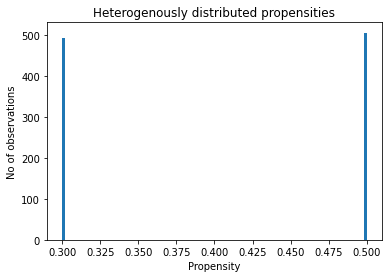

In [ ]:
heterogenous_propensities_sim = make_causal_effect(
    n_samples=1000,
    treatment_propensity=lambda X: 0.3 + (X[:, 0] > 0) * 0.2,
    return_propensity=True,
    return_as_dict=True
)

plt.title("Heterogenously distributed propensities")
plt.xlabel("Propensity")
plt.ylabel("No of observations")
plt.hist(heterogenous_propensities_sim['propensity'], bins=100)
plt.show()

The propensity can also be randomly allocated, together with covariate dependence or not. Note that even if the propensity is completely random and does not depend on covariates, the function must still use the argument `X` to calculate a random vector with the appropriate size.

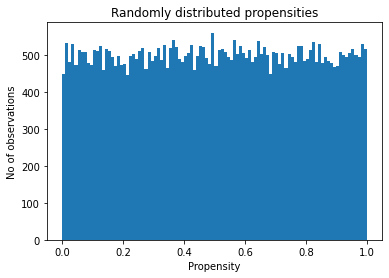

In [ ]:
random_propensities_sim = make_causal_effect(
    n_samples=50000,
    treatment_propensity=lambda X: np.random.uniform(size=X.shape[0]),
    return_propensity=True,
    return_as_dict=True
)

plt.title("Randomly distributed propensities")
plt.xlabel("Propensity")
plt.ylabel("No of observations")
plt.hist(random_propensities_sim['propensity'], bins=100)
plt.show()

#### Treatment assignment

As seen above, every observation has a given treatment propensity - the chance that they are treated. Users can define how this propensity translates into actual treatment with the argument `treatment_assignment`. This argument takes a function, which must have an argument called `propensity`.

The default value for this argument is a function returning 1s with probability `propensity` and 0s otherwise. Any other function should always return either 0s or 1s for the data simulator to work as expected.

In [ ]:
causal_sim = make_causal_effect(
    treatment_assignment=lambda propensity: np.random.binomial(1, propensity)
)

While the case above is likely to be the most useful in practice, this argument accepts more complex relationships between an observation's propensity and the actual treatment assignment.

For example, if treatment is subject to rationing, then one could simulate data with 10 observations where only the samples with the highest (say, 3) propensity scores get treated, as below:

In [ ]:
rationed_treatment_sim = make_causal_effect(
    n_samples=10,
    treatment_propensity=lambda X: np.random.uniform(size=X.shape[0]),
    treatment_assignment=lambda propensity: propensity >= propensity[np.argsort(propensity)][-3],
    return_propensity=True,
    return_assignment=True,
    return_as_dict=True
)

In [ ]:
rationed_treatment = pd.DataFrame(
    np.column_stack((rationed_treatment_sim['propensity'], rationed_treatment_sim['treatment_assignment'])),
    columns = ['propensity', 'assignment']
    )

In [ ]:
rationed_treatment.sort_values('propensity')

,propensity,assignment
9,0.004224,0.0
5,0.137627,0.0
8,0.336856,0.0
2,0.360272,0.0
1,0.521297,0.0
0,0.548451,0.0
3,0.605906,0.0
7,0.623523,1.0
6,0.756268,1.0
4,0.784848,1.0


#### Treatment value

The `treatment` argument indicates the magnitude of the treatment for each observation assigned for treatment. Its value is always a function that must have an argument called `assignment`, as in the first example below.

In the simplest case, the treatment is a binary variable indicating whether or not a variable was treated. In other words, the treatment is the same as the assignment, as in the default value.

But users can also simulate data with heterogenous treatment, conditional on assignment. This is done by including a pararemeter `X` in the function, as shown in the second example below.

In [ ]:
binary_treatment_sim = make_causal_effect(
    n_samples=15,
    treatment=lambda assignment: assignment,
    return_assignment=True,
    return_treatment_value=True,
    return_as_dict=True
)

assert sum(binary_treatment_sim['treatment_assignment'] - binary_treatment_sim['treatment_value'][0]) == 0

Heterogenous treatments may occur in settings where treatment intensity, conditional on assignment, varies across observations. Please note the following:

* the heterogenous treatment amount may or may not depend on covariates, but either way, if treatment values are heterogenous, then `X` needs to be an argument of the function passed to `treatment`, if nothing else to make sure the shapes match; and

* if treatments are heterogenous, then it is important to multiply the treatment value with the `assignment` argument to ensure that observations that are not assigned to be treated are indeed not treated (the function will return an `AssertionError` otherwise).

In [ ]:
hetereogenous_treatment_sim = make_causal_effect(
    n_samples=15,
    treatment=lambda assignment, X: assignment * np.random.uniform(size=X.shape[0]),
    return_assignment=True,
    return_treatment_value=True,
    return_as_dict=True
)

In contrast to the function above, in the chunk below the function `make_causal_effect` fails because a treatment value is also assigned to observations that were not assigned for treatment.

In [ ]:
test_fail(
    make_causal_effect, 
    kwargs=dict(treatment=lambda assignment, X: assignment + np.random.uniform(size=X.shape[0]))
)

#### Treatment effect

The treatment effect can be homogenous, ie, is doesn't depend on any other characteristic of the individual observations (in other words, does not depend on $X_i$), or heterogenous (where the treatment effect on $Y_i$ does depend on each observation's $X_i$). This can be done by specifying the causal relationship through a lambda function, as below:

In [ ]:
homogenous_effects_sim = make_causal_effect(
        treatment_effect=lambda treatment_value: treatment_value,
        return_treatment_value=True,
        return_as_dict=True
)

assert (homogenous_effects_sim['treatment_effect'] == homogenous_effects_sim['treatment_value']).all()

heterogenous_effects_sim = make_causal_effect(
        treatment_effect=lambda treatment_value, X: np.maximum(X[:, 1], 0) * treatment_value,
        return_treatment_value=True,
        return_as_dict=True
)

assert (heterogenous_effects_sim['treatment_effect'] != heterogenous_effects_sim['treatment_value']).any()

## References
::: {#refs}
:::

In [ ]:
#| echo: false
import nbdev; nbdev.nbdev_export()